<a href="https://colab.research.google.com/github/tumble-weed/GANs/blob/master/mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Torch.functional and dropout, how do you indicate if training is ON? if you are using functional is it that you are dropping out all the time?
**Yes, the mode collapse was due to the constantly ON dropout in the Generator (because the same units are dropped out for all the samples in a batch?) **

In [1]:
'''Uncomment for Colab'''
# !pip install -I --no-cache-dir pillow

    100% |████████████████████████████████| 2.0MB 2.0MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
import torch,torchvision
from matplotlib import pyplot as plt
import numpy as np
import os
tensor_to_numpy = lambda t:t.detach().cpu().numpy()
is_cuda = torch.cuda.is_available()

In [0]:
# 1. reading data, data_loader
# 2. make the G and the D
# 3. Define losses, optimizer, training_loop
# 4. view samples, graph of losses

**Define accuracy( needed for val loss)**

In [0]:
def accuracy(bpred,by,topk=(1,)):
    with torch.no_grad():
        
        K = max(topk) # K is the max number of values we might be interested in
        topK_values,topK_idx= bpred.topk(K,dim=1,largest=True,sorted=True)
#         topK_idx = topK_idx.t()
        in_topK = topK_idx.eq(by.unsqueeze(1).expand_as(topK_idx))
        
        res = []
        batch_size = bpred.shape[0]
        for k in topk:
            in_any_topk = in_topK[:,:k].sum().float()
            res.append(in_any_topk*(100./batch_size))
        return res


**Read in the train and validation sets, and make data loaders**

In [0]:
preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           lambda t: 2*(t- 0.5),
                                            lambda t:t.view(-1)])
mnist_train = torchvision.datasets.MNIST(train=True,root='data',download=True,transform = preprocess)
batch_size = 64
num_workers = 4

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,num_workers = num_workers,shuffle=True)

mnist_val = torchvision.datasets.MNIST(train=False,root='data',download=True,transform=preprocess)
val_loader = torch.utils.data.DataLoader(mnist_val,batch_size=batch_size,num_workers=num_workers,shuffle=False)

**Define the models for Discriminator**

In [7]:
import torch.nn as nn
import torch.nn.functional as F



class Discriminator(torch.nn.Module):
    def __init__(self,input_size,hid_layer_sizes):
        super(Discriminator,self).__init__()
        lin_layers = []
        self.input_size = input_size
        self.hid_layer_sizes = hid_layer_sizes
        for ls in hid_layer_sizes:
            l = torch.nn.Linear(input_size,ls,bias=True)
            lin_layers.append(l)
            input_size = ls

        l = torch.nn.Linear(input_size,1,bias=True)
        lin_layers.append(l)
        self.lin_layers = torch.nn.ModuleList(lin_layers)
    def forward(self,x):
        for l in self.lin_layers:
            x = l(x)
            x = torch.nn.functional.leaky_relu(x,0.2)
            x = torch.nn.functional.dropout(x,p=0.3,training=self.training)
        return x


D_hid_layer_sizes = [128,64,32]
D = Discriminator(784,D_hid_layer_sizes)
print(D(torch.ones(3,784).float()).shape)
if is_cuda:
    D.cuda()
D_params = [p for l in D.lin_layers for p in list(l.parameters())]
        
    


torch.Size([3, 1])


**Define the Generator**

In [8]:
# '''
# does dropout in generator help?

class Generator(torch.nn.Module):
    def __init__(self,input_size,hid_layer_sizes,output_size):
        super(Generator,self).__init__()
        lin_layers = []
        for ls in hid_layer_sizes:
            l = torch.nn.Linear(input_size,ls)
            lin_layers.append(l)
            input_size = ls
        l = torch.nn.Linear(input_size,output_size)
        lin_layers.append(l)
        self.lin_layers= torch.nn.ModuleList(lin_layers)
        pass
    def forward(self,x):
        for i,l in enumerate(self.lin_layers[:-1]):
            x = l(x)
            x = torch.nn.functional.leaky_relu(x,0.2)
            x = torch.nn.functional.dropout(x,p=0.3,training=self.training)
        i +=1
        x = self.lin_layers[-1](x)
        x = torch.nn.functional.tanh(x)
        return x


noise_dim = 100
G_hid_layer_sizes = [32,64,128]
G = Generator(noise_dim,G_hid_layer_sizes,28*28)
v = torch.ones(1,100).float()
G(v)
if is_cuda:
    G.cuda()
    v = v.cuda()
print(G(v).shape)
G_params = [p for l in G.lin_layers for p in list(l.parameters())]


        


torch.Size([1, 784])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [9]:
print(D,G)

Discriminator(
  (lin_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
) Generator(
  (lin_layers): ModuleList(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=784, bias=True)
  )
)


** define the optimizers and training loop **

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


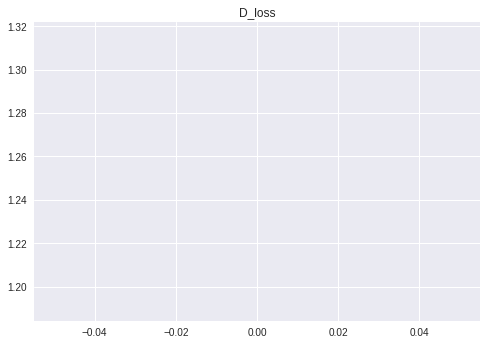

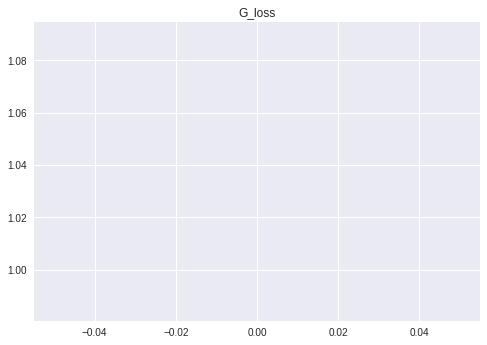

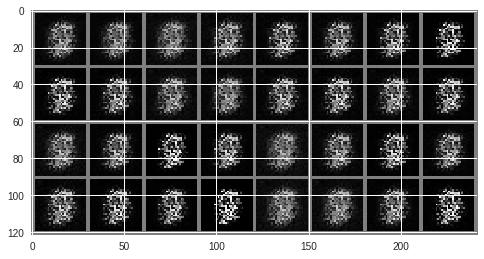

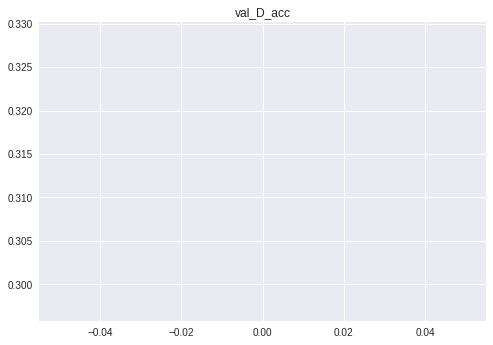

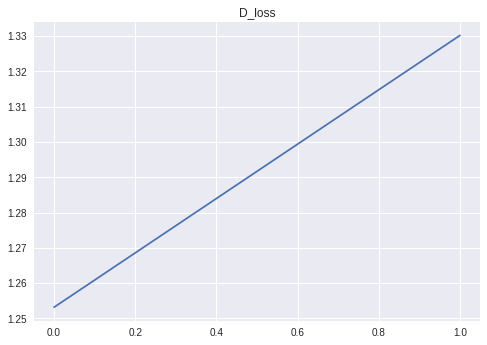

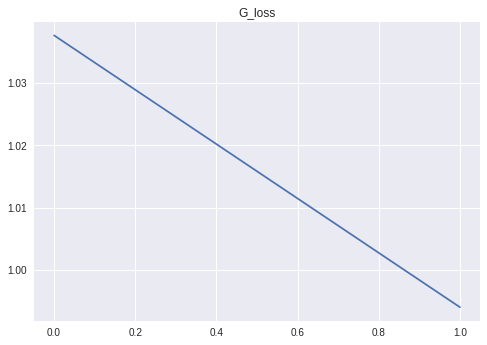

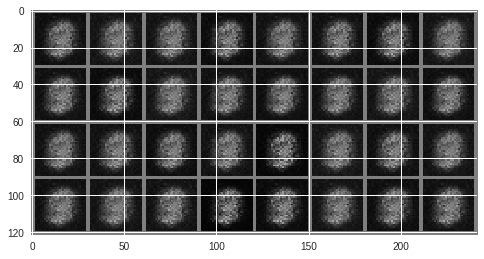

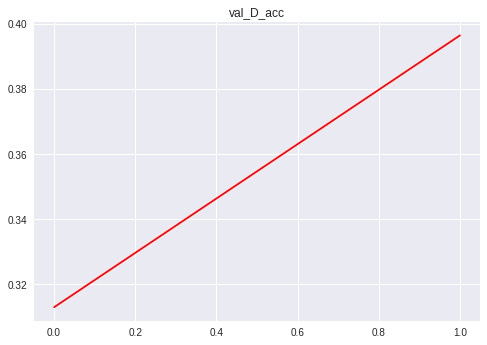

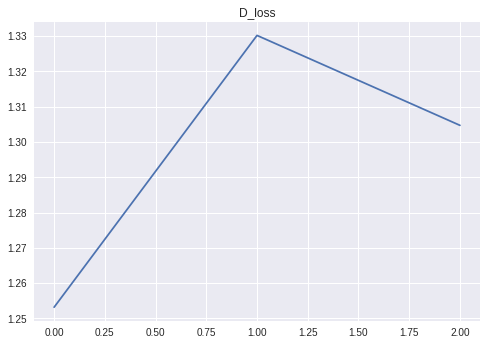

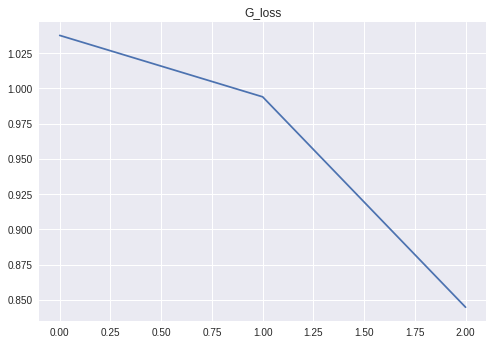

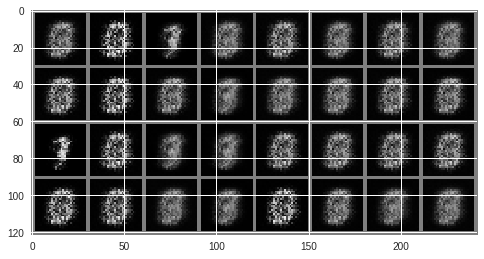

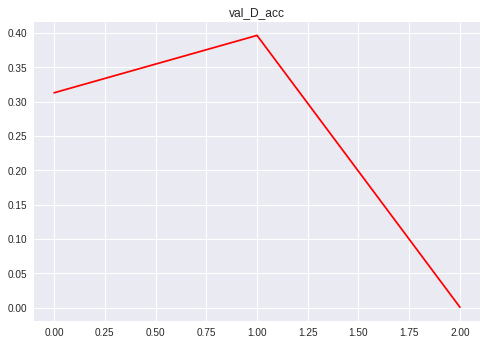

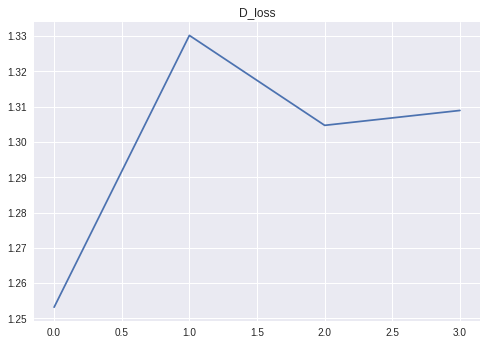

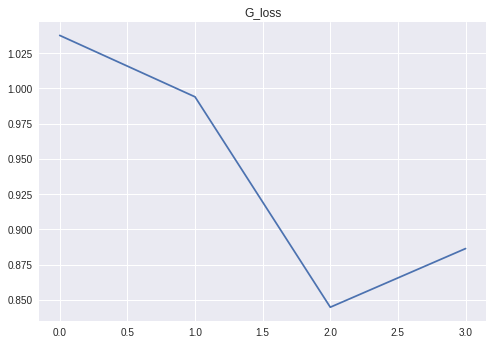

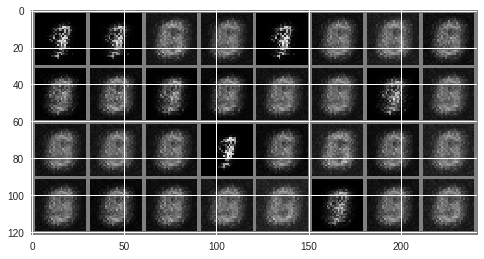

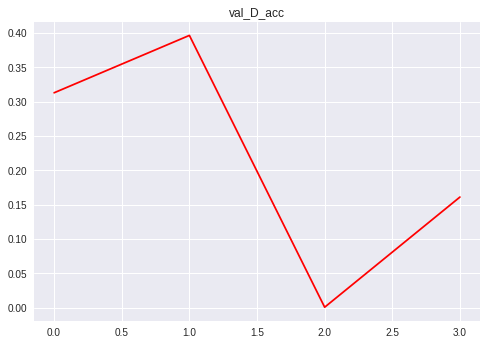

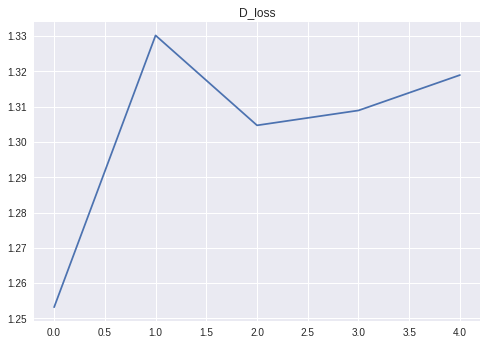

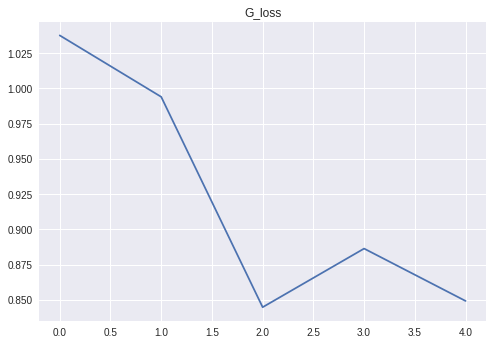

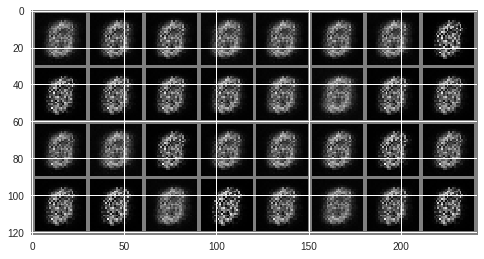

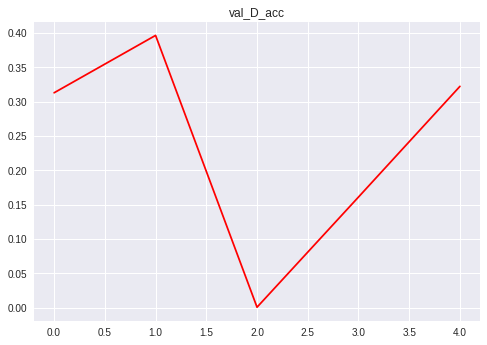

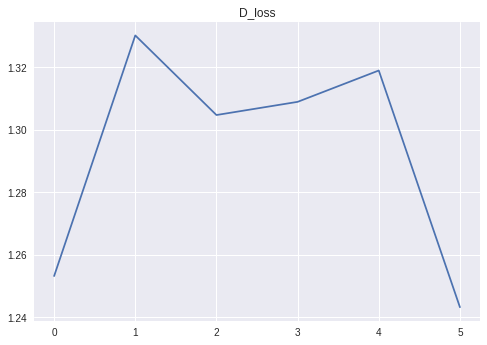

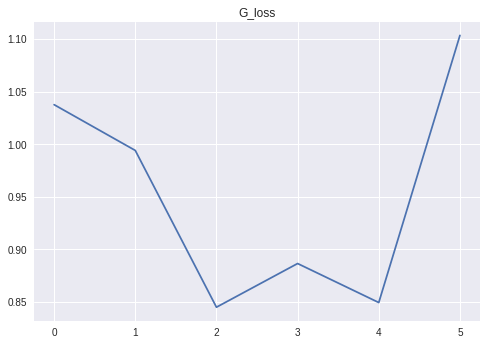

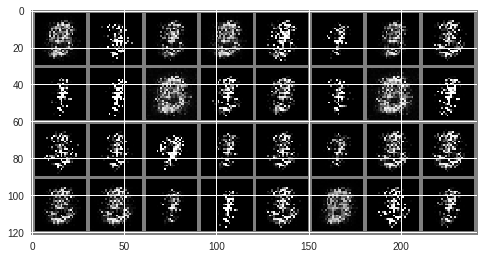

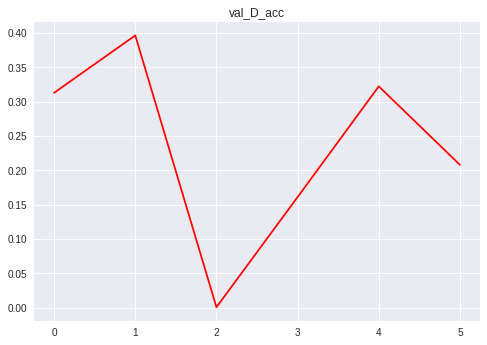

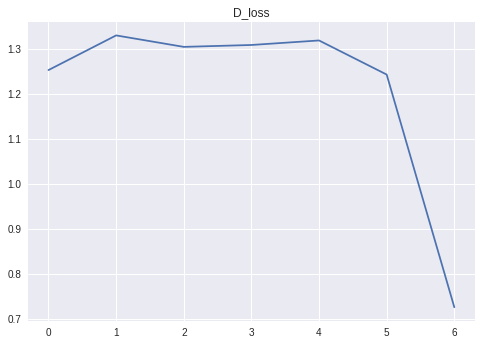

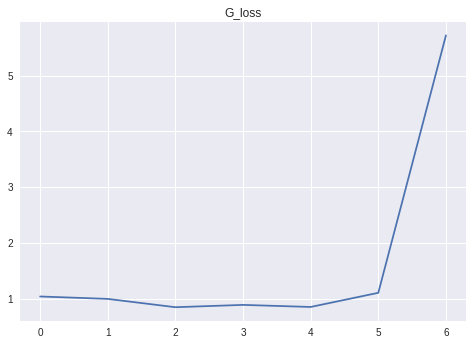

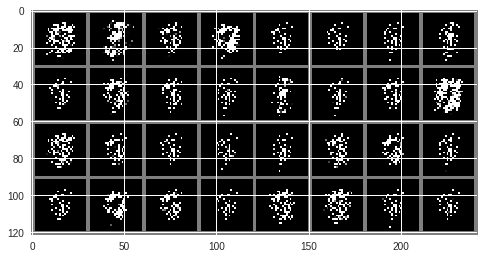

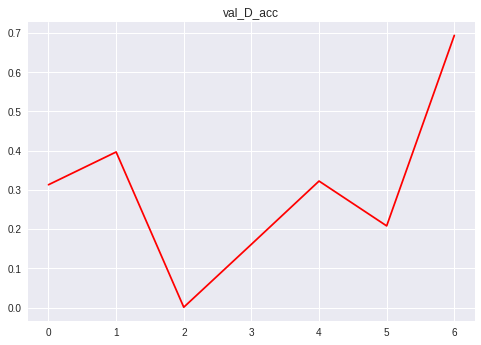

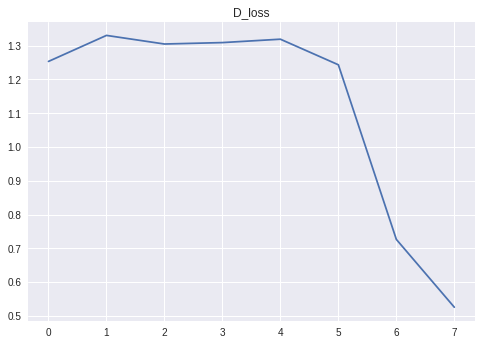

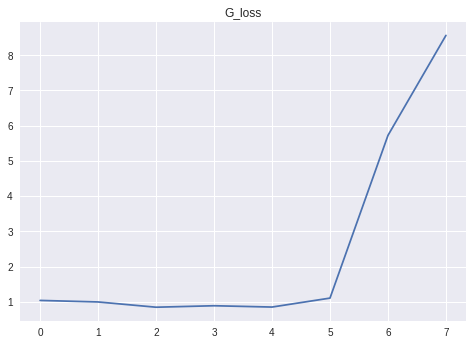

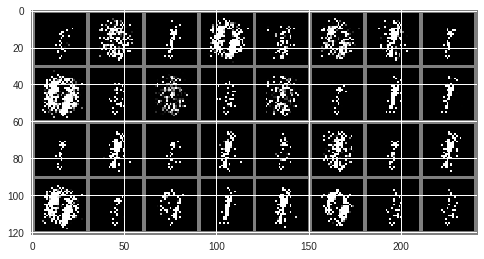

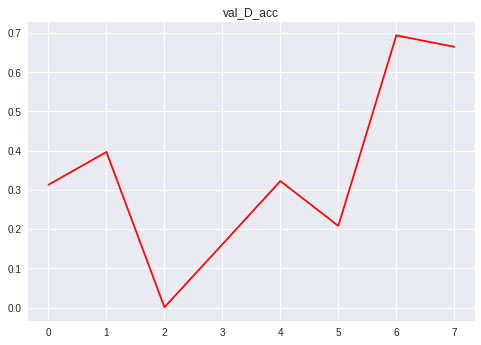

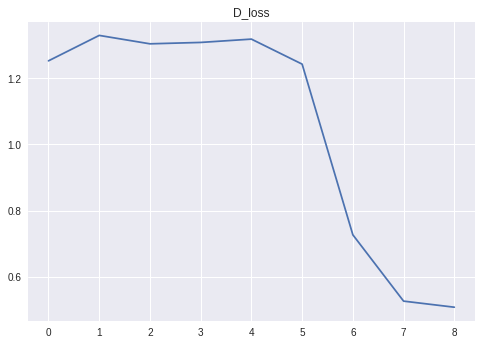

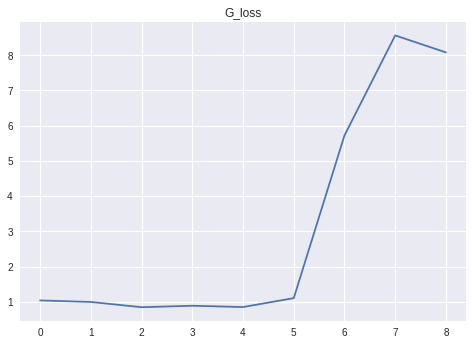

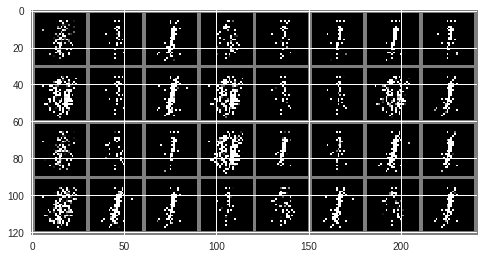

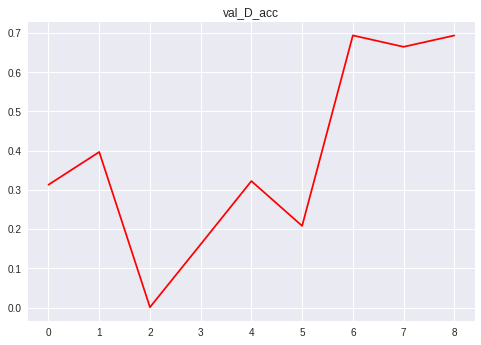

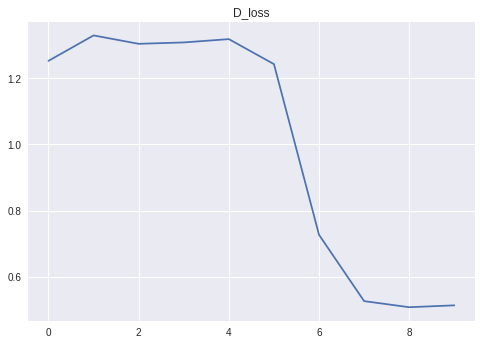

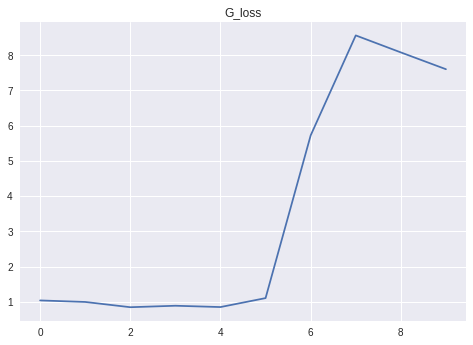

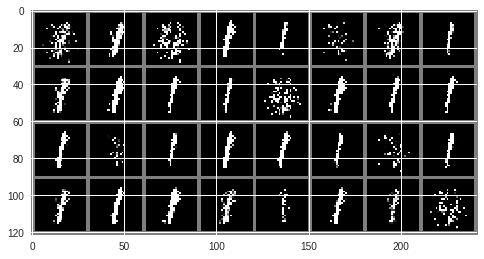

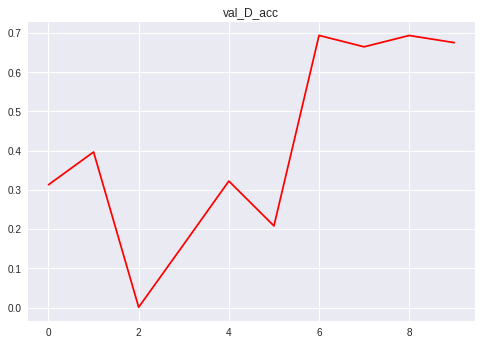

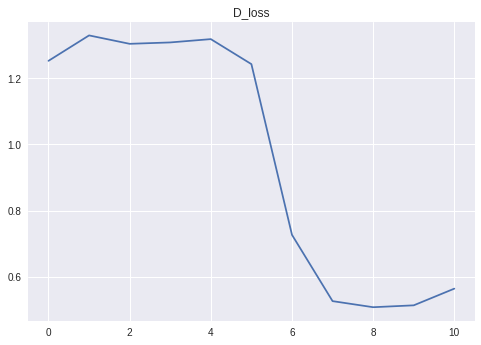

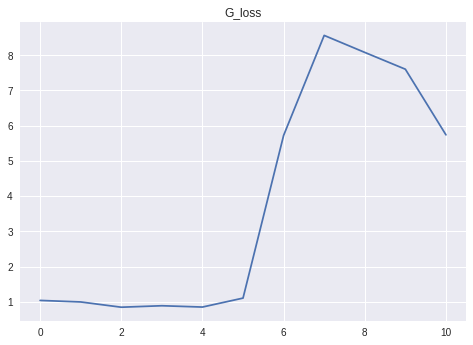

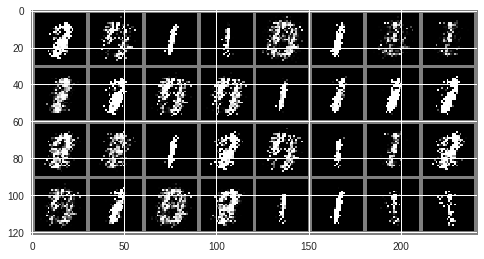

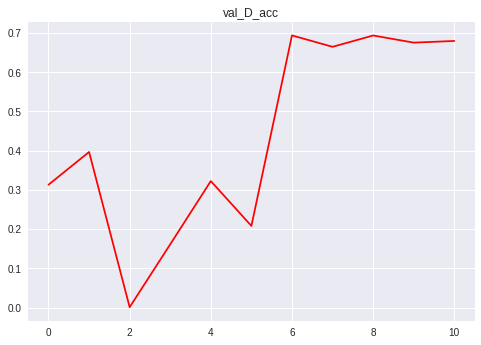

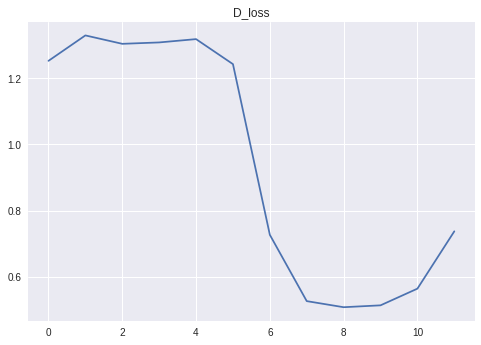

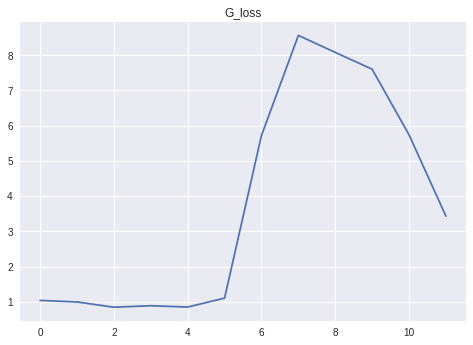

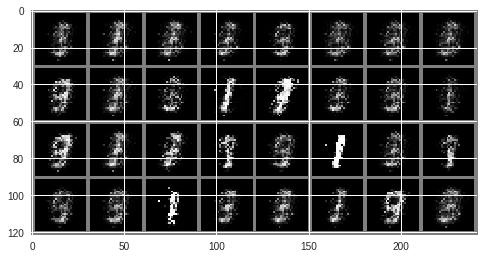

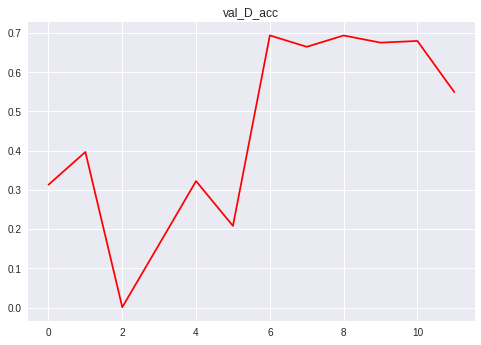

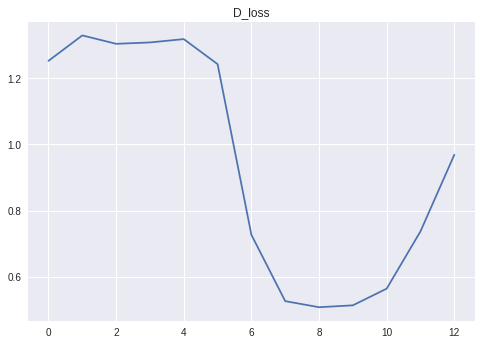

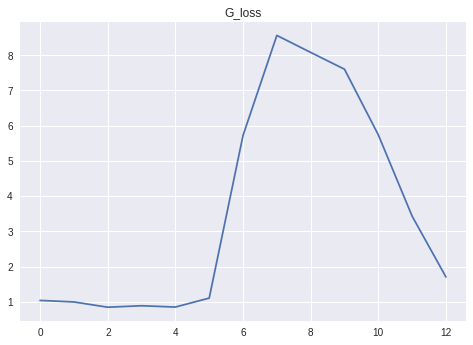

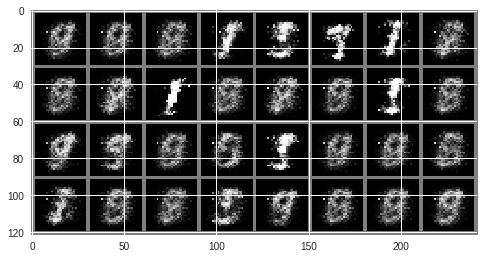

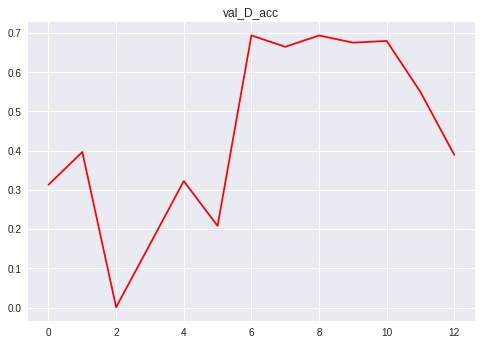

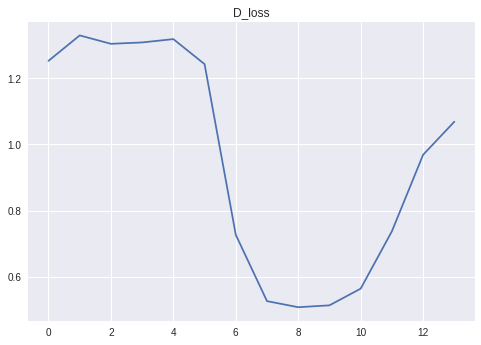

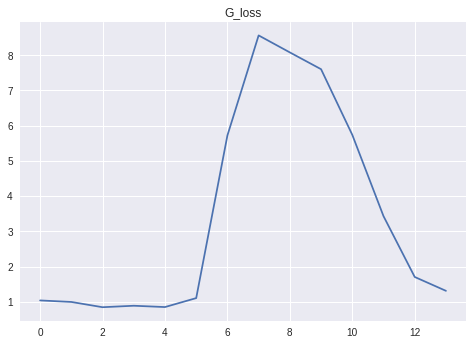

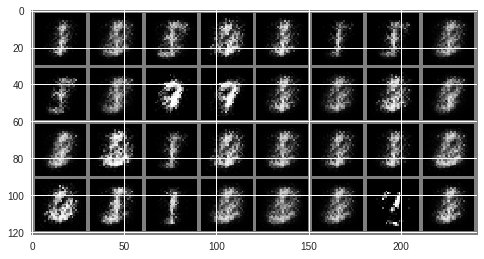

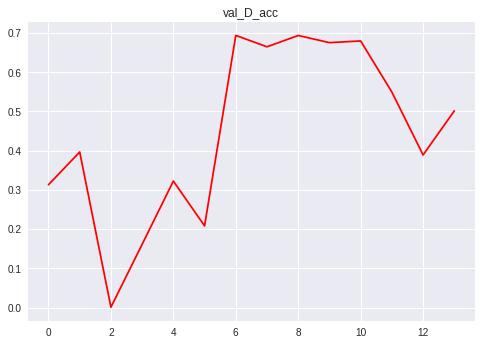

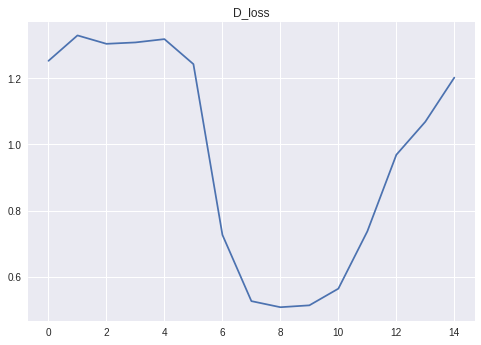

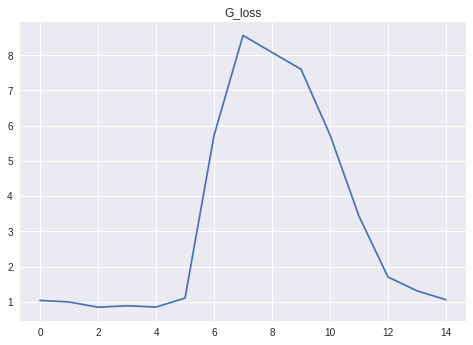

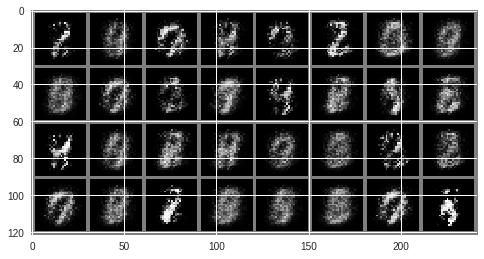

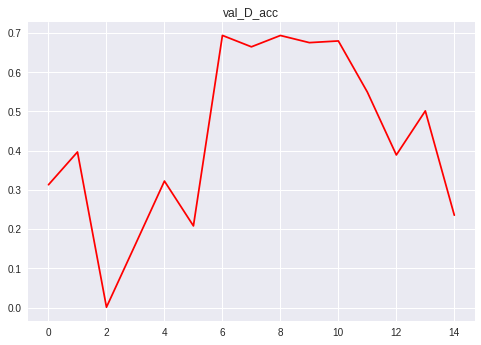

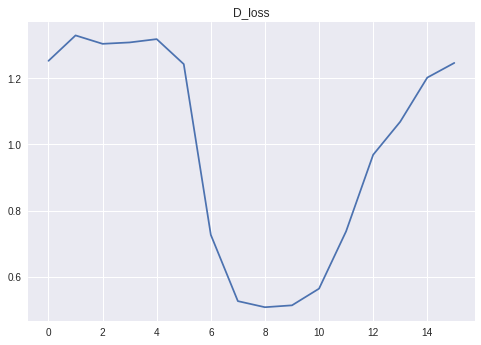

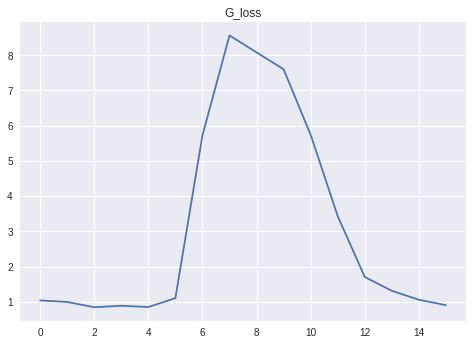

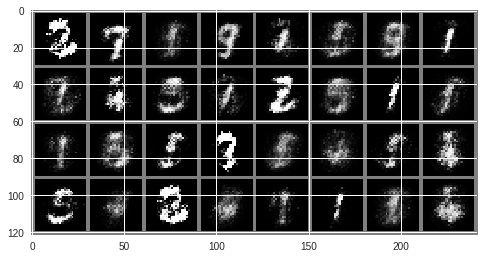

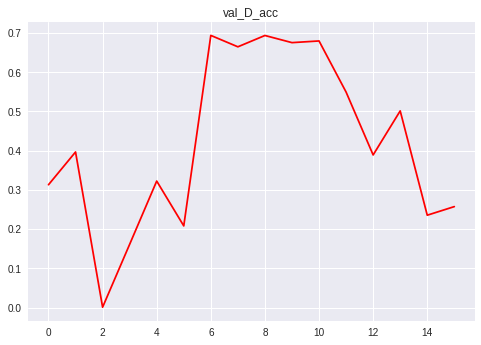

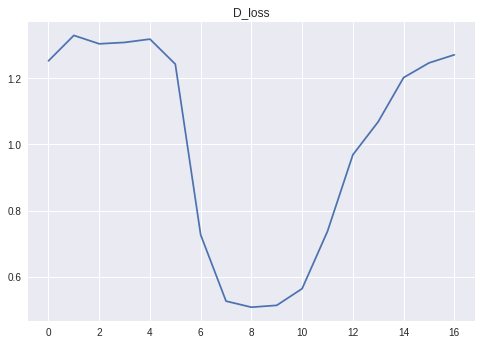

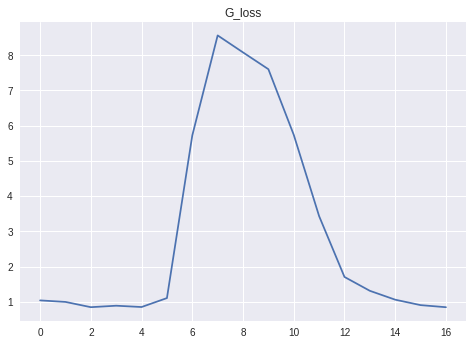

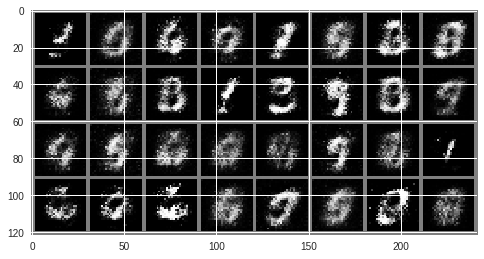

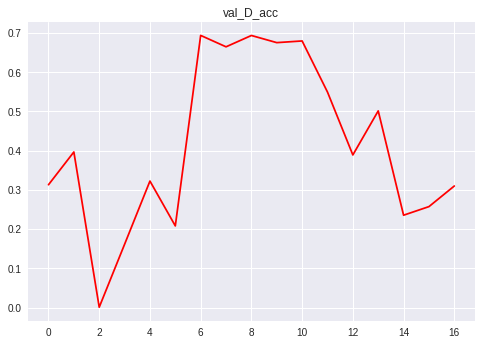

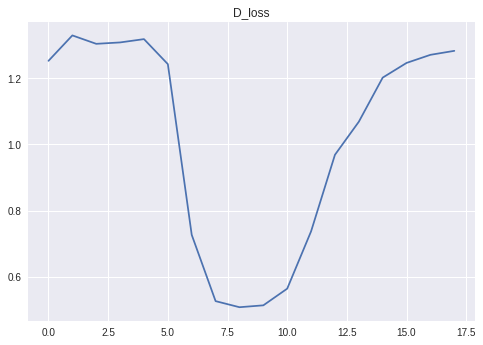

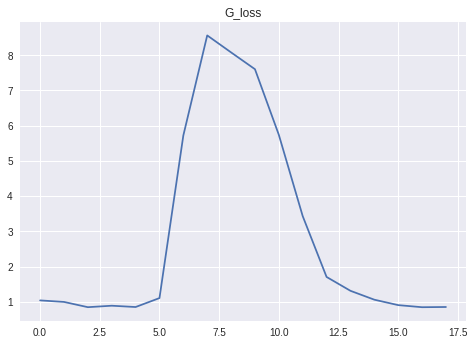

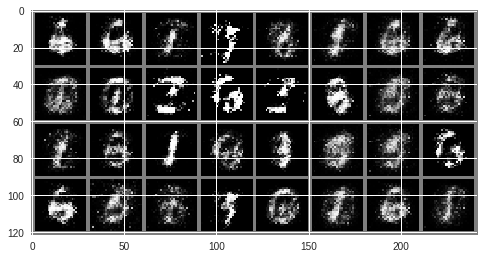

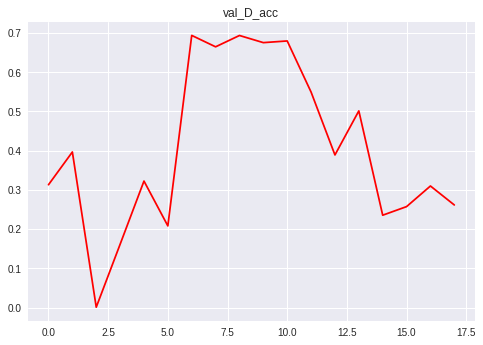

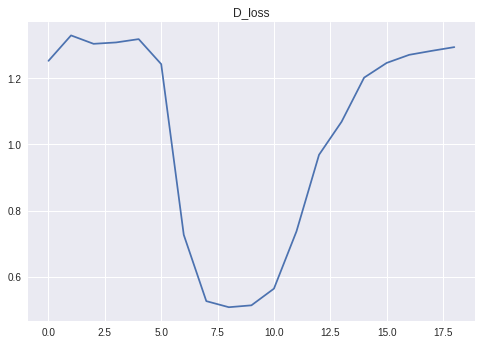

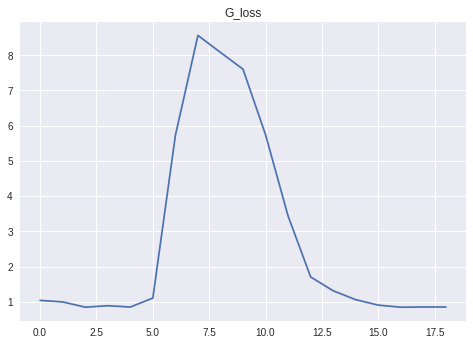

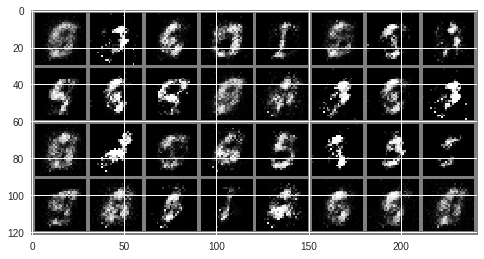

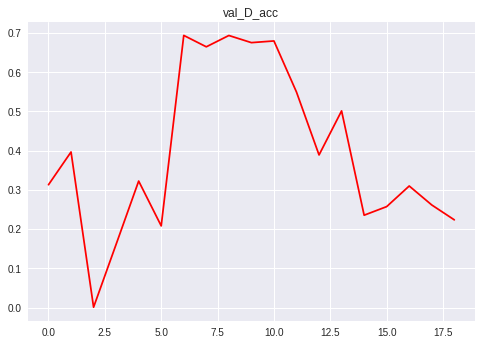

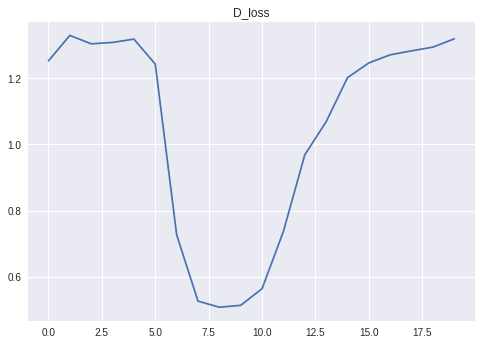

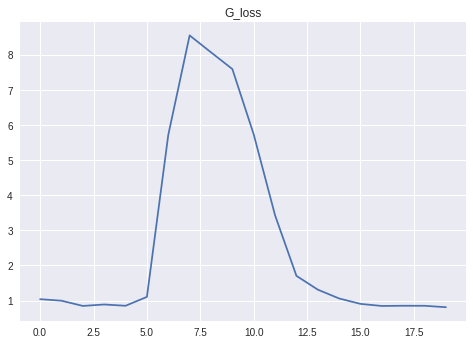

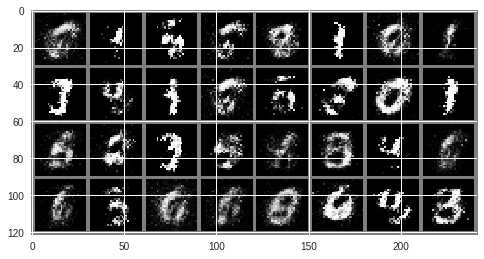

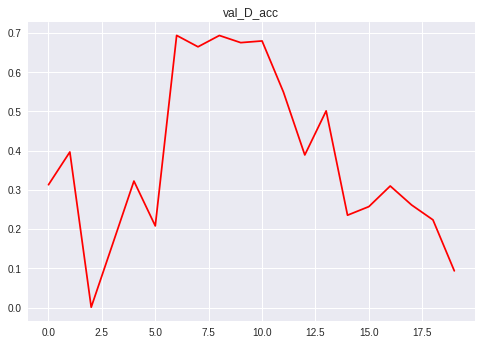

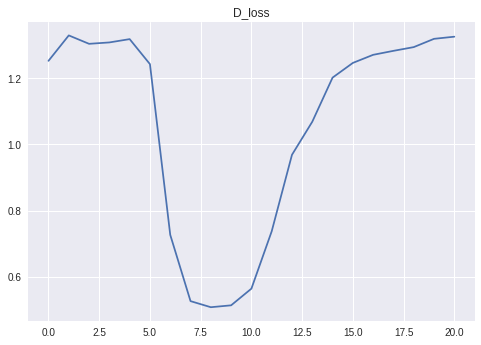

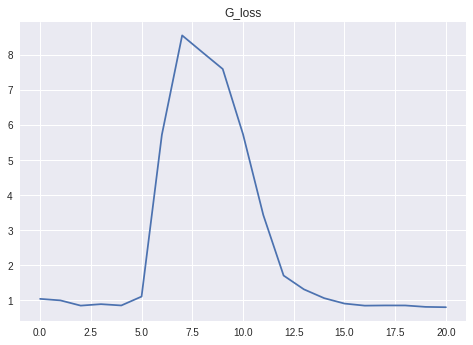

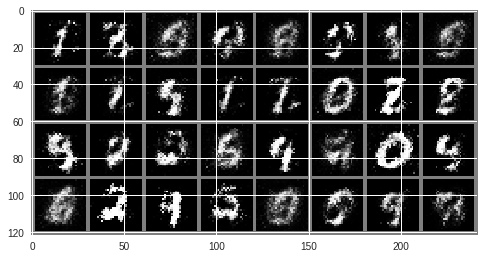

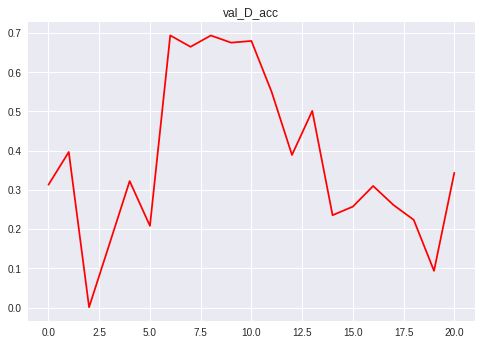

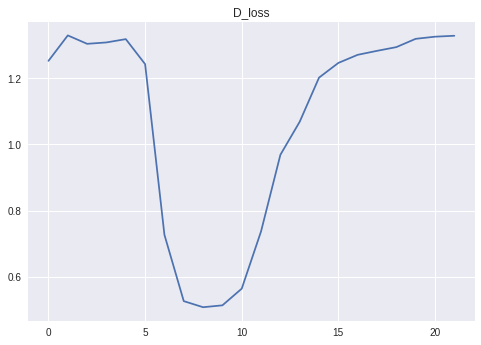

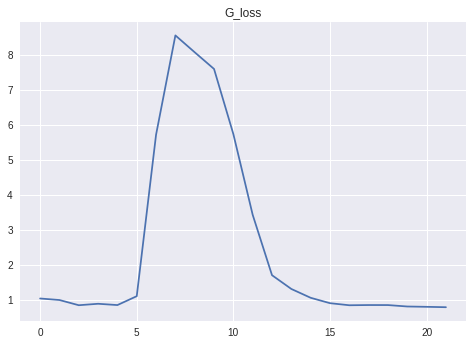

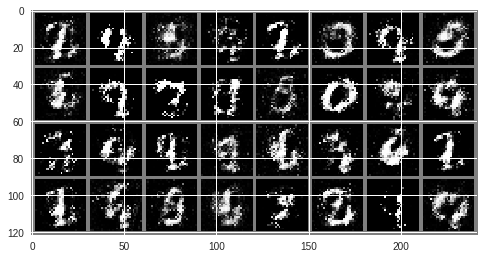

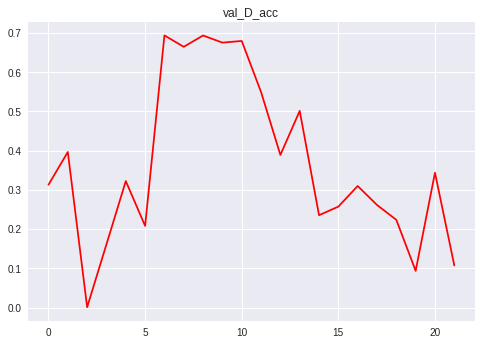

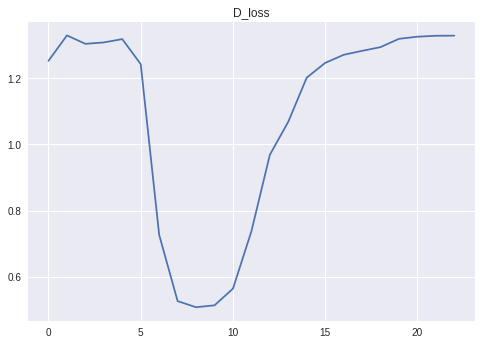

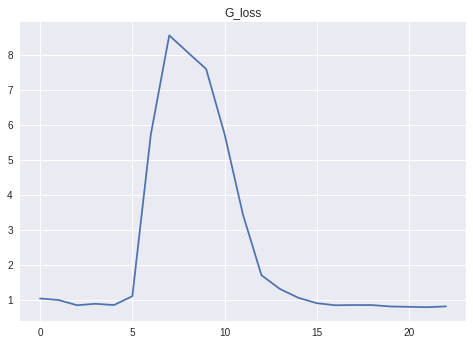

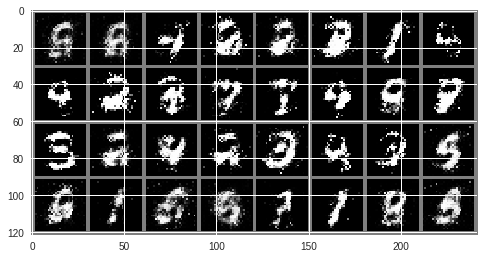

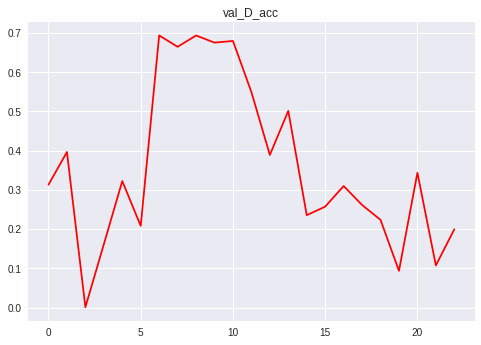

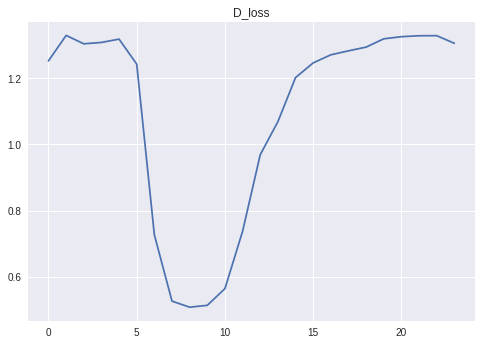

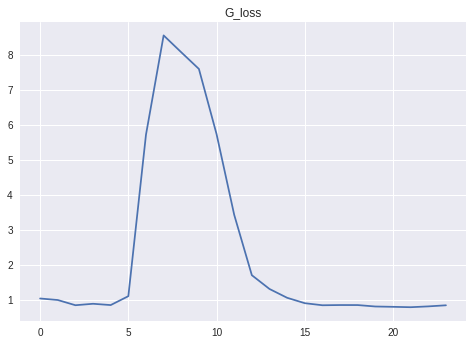

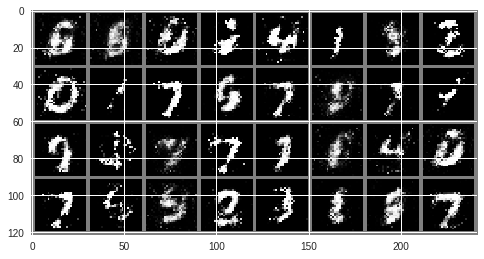

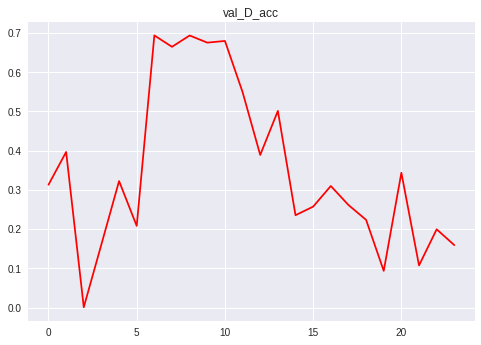

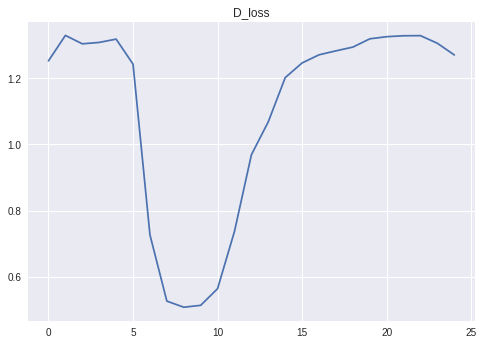

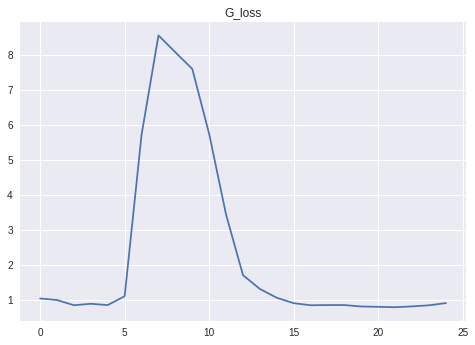

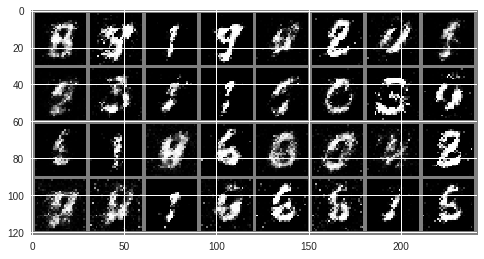

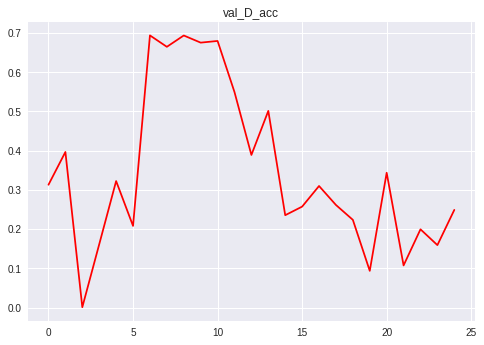

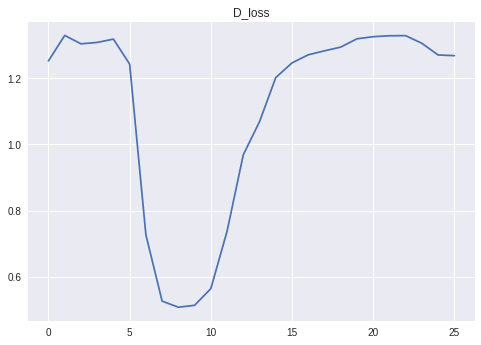

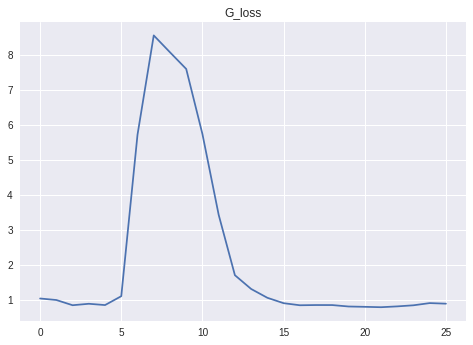

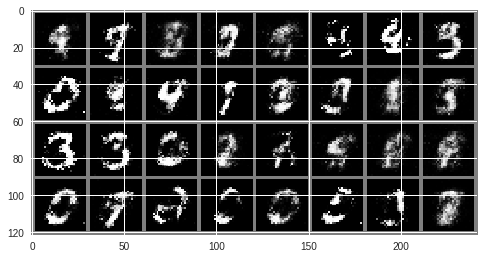

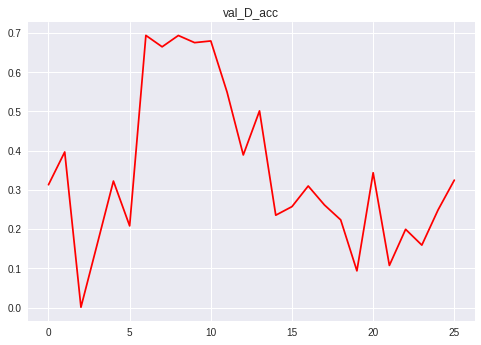

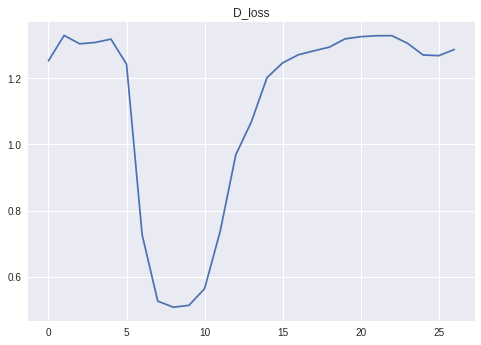

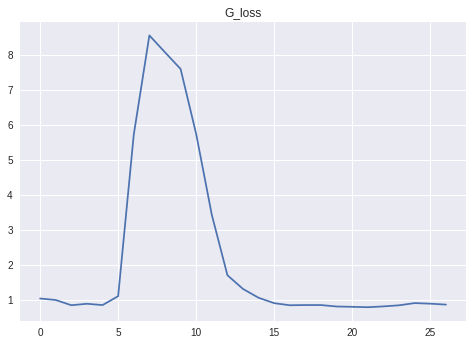

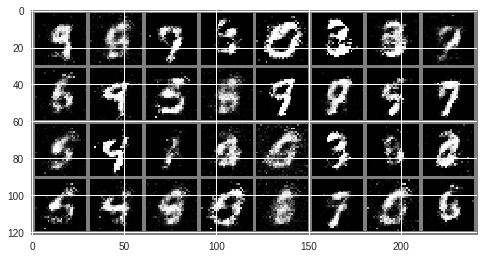

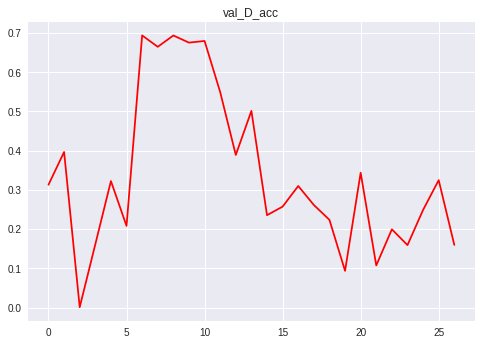

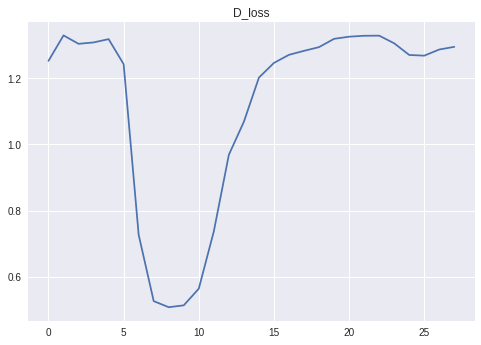

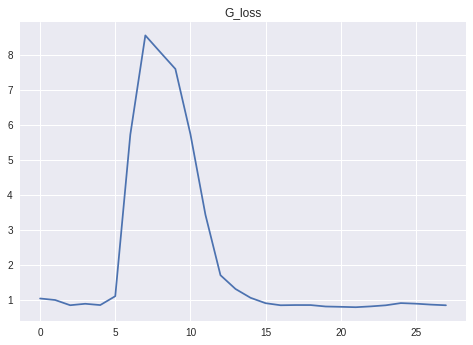

In [0]:
D.train()
G.train()
from tqdm import tqdm_notebook

opt_G = torch.optim.Adam(G_params,lr = 0.002)
opt_D = torch.optim.Adam(D_params,lr = 0.002)
nepochs = 100
trends = {'D_loss':[],'G_loss':[],'val_D_loss':[],'val_D_acc':[]}
viz_freq = 1
val_freq = 1
for e in tqdm_notebook(range(nepochs)):
    across_batch_trends = {'D_loss':0.,'G_loss':0.}
    for bix,(bx,by) in enumerate(train_loader):
        if is_cuda:
            bx = bx.cuda()
        ''' Discriminator training '''
        bsize = bx.shape[0]
        D_bx = D(bx)
        
        noise = 2*torch.rand(bx.shape[0],noise_dim) - 1
        if is_cuda:
            noise = noise.cuda()
        bfake = G(noise)
        D_fake = D(bfake)
        
        D_loss_real = torch.nn.functional.binary_cross_entropy_with_logits(D_bx,torch.ones_like(D_bx))
        D_loss_fake = torch.nn.functional.binary_cross_entropy_with_logits(D_fake,torch.zeros_like(D_bx))
        

        D_loss = D_loss_real + D_loss_fake
        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()
        
        ''' Generator training '''
        noise = 2*torch.rand(bx.shape[0],noise_dim) -1 
        if is_cuda:
            noise = noise.cuda()
        bfake = G(noise)
        D_fake = D(bfake)
        
        G_loss_targets = torch.ones_like(D_bx)
        G_loss = torch.nn.functional.binary_cross_entropy_with_logits(D_fake,G_loss_targets)
        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()
        
        ''' Statistics '''
        across_batch_trends['D_loss'] = (across_batch_trends['D_loss'] *bix + tensor_to_numpy(D_loss))/(bix+1.)
        across_batch_trends['G_loss'] = (across_batch_trends['G_loss'] *bix + tensor_to_numpy(G_loss))/(bix+1.)
        
        
    trends['D_loss'].append(across_batch_trends['D_loss'])
    trends['G_loss'].append(across_batch_trends['G_loss'])
    
    if e%viz_freq == 0:
        plt.figure()
        plt.plot(trends['D_loss'])
        plt.title('D_loss')
        plt.show()
        
        plt.figure()
        plt.plot(trends['G_loss'])
        plt.title('G_loss')
        plt.show()
        
        ''' Samples '''
        G.eval()
        bfake = G(noise)
        fake = torchvision.utils.make_grid(bfake.detach().view(-1,1,28,28))
        fake_ = tensor_to_numpy(fake/2. + 0.5)
        fake_ = np.transpose(fake_,(1,2,0))
        plt.figure()
        plt.imshow(fake_)
        plt.show()
        G.train()

    if True and (e % val_freq == 0):
        ''' Validation error'''
        v_loss = 0.
        v_acc = 0.
        for v_ix,(v_bx,_) in enumerate(val_loader):
            if is_cuda:
                v_bx = v_bx.cuda()
            D_v_bx = D(v_bx)
            v_b_acc = torch.sum((D_v_bx>0.5).float())/D_v_bx.shape[0]
            v_b_loss = torch.nn.functional.binary_cross_entropy_with_logits(D_v_bx,torch.ones_like(D_v_bx))
            v_loss = v_loss*v_ix + v_b_loss
            v_loss = v_loss/(v_ix+1)
            

            v_acc = v_acc * v_ix + v_b_acc
            v_acc = v_acc/(v_ix+1)
        trends['val_D_loss'].append(v_loss)
        trends['val_D_acc'].append(v_acc)
        
        plt.figure()
        plt.plot(trends['val_D_acc'],'r')
        plt.title('val_D_acc')
        plt.show()

            
            
    pass